# Installing the libraries

In [1]:
!pip install ray==1.0.0
!pip install or-gym

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.9/22.9 MB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 111.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 KB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.5/90.5 KB 16.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.2/71.2 KB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 KB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 KB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 KB 10.6 MB/s eta 0:00:00
  Created wheel for gpustat: filename=gpustat-1.0.0-py3-none-any.whl size=19887 sha256=c68f1de088764cf1b34e191ad29926d3f54ed6a8be706

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gym: filename=gym-0.19.0-py3-none-any.whl size=1663114 sha256=528c65b7e8e3ddeaaeb782f593425e91a9fd007d4a74096ee6b3055093278809
  Stored in directory: /root/.cache/pip/wheels/11/36/28/628f4dd3779e4037a6fca1aaed76827ffa4315c3ab6bfadcf6
Successfully built gym
  Attempting uninstall: cloudpickle
    Found existing installation: cloudpickle 2.2.1
    Uninstalling cloudpickle-2.2.1:
      Successfully uninstalled cloudpickle-2.2.1
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2


In [2]:
import or_gym
from or_gym.utils import create_env
import ray
from ray.rllib.agents.ppo import PPOTrainer
from ray import tune
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
#Registering the inv evironment

def register_env(env_name, env_config={}):
    env = create_env(env_name)
    tune.register_env(env_name, 
        lambda env_name: env(env_name,
            env_config=env_config))

# Environment and RL Configuration Settings
env_name = 'InvManagement-v1'
# env_name = "Knapsack-v0"
env_config = {} # Change environment parameters here
rl_config = dict(
    env=env_name,
    num_workers=2,
    env_config=env_config,
    model=dict(
        vf_share_layers=False,
        fcnet_activation='elu',
        fcnet_hiddens=[256, 256]
    ),
    lr=1e-5
)
 
# Register environment
register_env(env_name, env_config)

In [4]:
#initialising ray
#Training the agent on PPO algorithm as it's a lot easier to train for a demo


ray.init(ignore_reinit_error=True)
agent = PPOTrainer(env=env_name,
    config=rl_config)
 
results = []
for i in range(150):
    res = agent.train()
    results.append(res)
    if (i+1) % 5 == 0:
        print('\rIter: {}\tReward: {:.2f}'.format(
                i+1, res['episode_reward_mean']), end='')
ray.shutdown()

2023-02-08 04:11:55,355	INFO services.py:1164 -- View the Ray dashboard at http://127.0.0.1:8265
2023-02-08 04:11:56,805	INFO logger.py:200 -- pip install 'ray[tune]' to see TensorBoard files.
2023-02-08 04:11:56,825	WARNING logger.py:342 -- Could not instantiate TBXLogger: No module named 'tensorboardX'.
2023-02-08 04:11:56,834	INFO trainer.py:591 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
2023-02-08 04:11:56,840	INFO trainer.py:616 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=484) WARNING:tensorflow:From /usr/local/lib/python3.8/dist-packages/tensorflow/python/compat/v2_compat.py:107: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=484) Instructions for updating:
(pid=484) non-resource variables are not supported in the long term
(pid=484) WARNING:tensorflow:From /usr/local/lib/python3.8/d

Iter: 150	Reward: 120.54

In [5]:
checkpoint = agent.save()
print(checkpoint)

/root/ray_results/PPO_InvManagement-v1_2023-02-08_04-11-56a_wr2xs7/checkpoint_150/checkpoint-150


In [6]:
temp = agent.get_policy()
temp

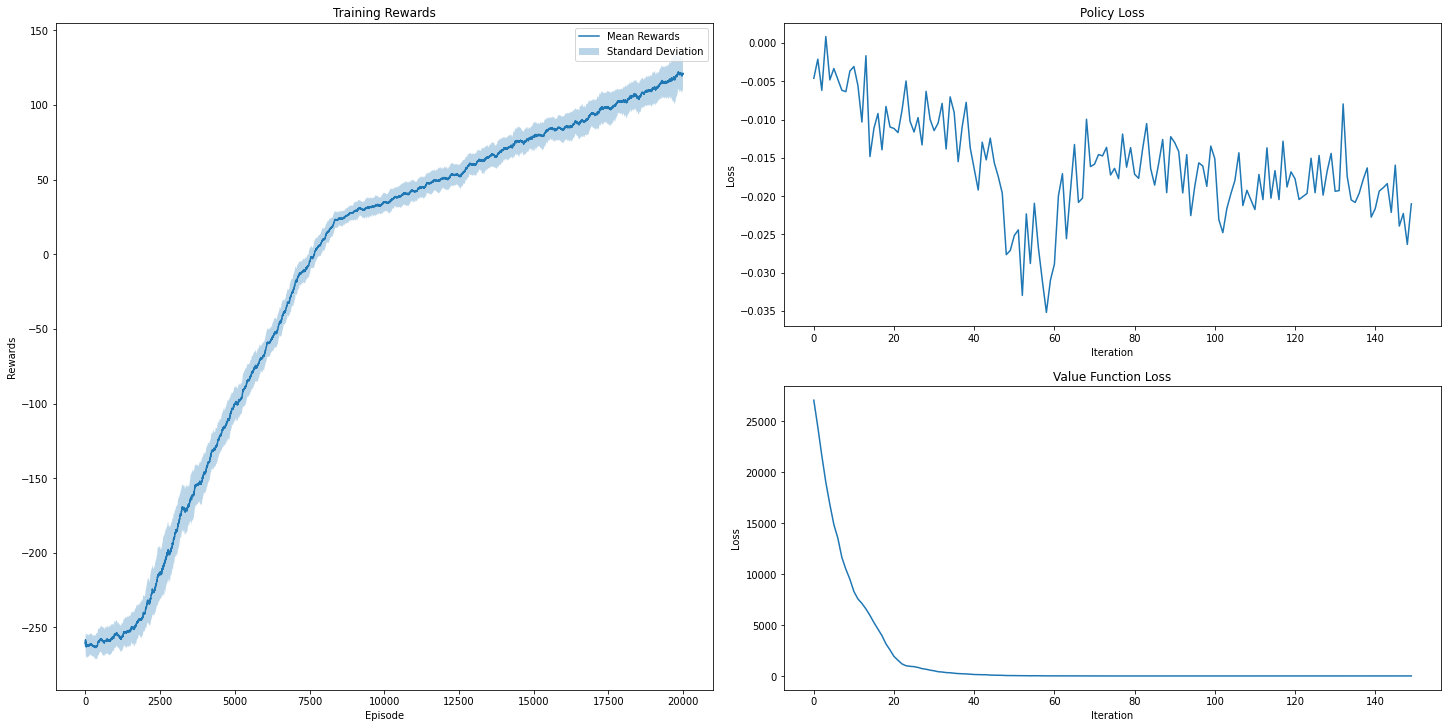

In [25]:
#Extracting the rewards for each episode
rewards = np.hstack([i['hist_stats']['episode_reward'] 
    for i in results])
#Extracting the plicy loss for each episode
pol_loss = [
    i['info']['learner']['default_policy']['policy_loss'] 
    for i in results]
#Extracting the value function loss or sale loss for each episode
vf_loss = [
    i['info']['learner']['default_policy']['vf_loss'] 
    for i in results]
p = 100
mean_rewards = np.array([np.mean(rewards[i-p:i+1]) 
                if i >= p else np.mean(rewards[:i+1]) 
                for i, _ in enumerate(rewards)])
std_rewards = np.array([np.std(rewards[i-p:i+1])
               if i >= p else np.std(rewards[:i+1])
               for i, _ in enumerate(rewards)])
fig = plt.figure(constrained_layout=True, figsize=(20, 10))
gs = fig.add_gridspec(2, 4)
ax0 = fig.add_subplot(gs[:, :-2])
ax0.fill_between(np.arange(len(mean_rewards)), 
                 mean_rewards - std_rewards, 
                 mean_rewards + std_rewards, 
                 label='Standard Deviation', alpha=0.3)
ax0.plot(mean_rewards, label='Mean Rewards')
ax0.set_ylabel('Rewards')
ax0.set_xlabel('Episode')
ax0.set_title('Training Rewards')
ax0.legend()
ax1 = fig.add_subplot(gs[0, 2:])
ax1.plot(pol_loss)
ax1.set_ylabel('Loss')
ax1.set_xlabel('Iteration')
ax1.set_title('Policy Loss')
ax2 = fig.add_subplot(gs[1, 2:])
ax2.plot(vf_loss)
ax2.set_ylabel('Loss')
ax2.set_xlabel('Iteration')
ax2.set_title('Value Function Loss')
plt.show()